In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import re
import torch
from bertopic import BERTopic
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModel

C:\Users\joshu\AppData\Roaming\Python\Python311\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\joshu\AppData\Roaming\Python\Python311\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\joshu\AppData\Roaming\Python\Python311\site-packages\umap\distanc

In [2]:
#Import the data from the JSON file
print("Importing data and building DataFrame:")
start_time = time.time()
with open('data/cleanedAggregateData.json', 'r') as f:
    data = json.load(f)
end_time = time.time()
load_time = end_time - start_time
print("Data load time", load_time)
print(data[0])

Importing data and building DataFrame:
Data load time 0.017074108123779297
{'id': 'EJ1292238', 'title': 'What Makes a Good-Quality Language MOOC? An Empirical Study of Criteria to Evaluate the Quality of Online Language Courses from Learners&apos; Perspectives', 'author': 'Luo, Rong, Ye, Zixuan', 'description': "This paper focuses on quality assurance in language massive open online courses (LMOOCs). It is a qualitative study that adopts the grounded theory method and analyses evaluative comments on the quality of LMOOCs from learners' perspectives. With the data collected from 1,000 evaluations from English as a second language (ESL) learners on China's biggest MOOC platform &quot;iCourse&quot;, this study examines what has influenced learners' perceptions of LMOOCs and identifies the specific quality criteria of five types of them, including ESL courses for speaking, reading, writing, cultural studies, and integrated skills. The results of the study will lay a foundation for the esta

In [3]:
#Create dataframe
print("Data loaded, converting to DataFrame")
start_time = time.time()
df = pd.DataFrame(data)
end_time = time.time()
convert_time = end_time - start_time
print("Data successfully converted to DataFrame. Conversion time:", convert_time)

Data loaded, converting to DataFrame
Data successfully converted to DataFrame. Conversion time: 0.001994609832763672


In [6]:
# Load the SciBERT tokenizer and model
docs = df.subject.tolist()
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
encoded_docs = [tokenizer.encode(doc, add_special_tokens=True) for doc in docs]

# Convert the encoded documents back to strings
decoded_docs = [tokenizer.decode(doc) for doc in encoded_docs]

# Initialize BERTopic with the SciBERT embedding model
embedding_model = (model, tokenizer)
model = BERTopic(verbose=True, embedding_model=embedding_model)

# Fit the model on the decoded documents
topics, probabilities = model.fit_transform(decoded_docs)

# Get topics over time
pub_dates = df.publicationdateyear.tolist()
topics_over_time = model.topics_over_time(decoded_docs, pub_dates)

# Get topic information
model.get_topic_info()


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Batches: 100%|██████████| 40/40 [00:19<00:00,  2.07it/s]
2023-05-12 21:23:51,320 - BERTopic - Transformed do

,Topic,Count,Name
0,-1,476,-1_language_second_instruction_learning
1,0,181,0_education_technology_educational_student
2,1,109,1_teacher_teachers_language_second
3,2,72,2_writing_instruction_language_second
4,3,51,3_communication_intercultural_cultural_language
5,4,47,4_learning_computer_second_games
6,5,47,5_language_second_student_anxiety
7,6,45,6_instruction_assisted_meta_second
8,7,42,7_linguistics_computational_language_second
9,8,38,8_teacher_mathematics_school_teachers


In [8]:
#helper function to create WordClouds
def create_wordcloud(model, topic):
     text = {word: value for word, value in model.get_topic(topic)}
     wc = WordCloud(background_color="white", max_words=1000)
     wc.generate_from_frequencies(text)
     plt.imshow(wc, interpolation="bilinear")
     plt.axis("off")
     plt.show()

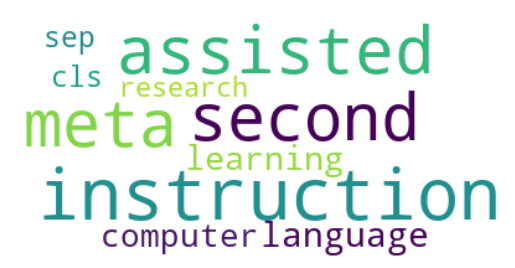

In [19]:
create_wordcloud(model, topic=6)

In [10]:
model.visualize_topics()

In [11]:
topics_to_include = list(range(0, 17))
model.visualize_barchart(topics= topics_to_include, width=300)

In [12]:
model.visualize_hierarchy()

In [13]:
hierarchical_topics = model.hierarchical_topics(docs)
model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 16/16 [00:00<00:00, 290.00it/s]


In [14]:
model.visualize_heatmap()

In [15]:
model.visualize_topics_over_time(topics_over_time, topics=[1, 3, 4, 5, 6, 7, 8, 9, 10])
#can innclude topics changing topics_over_time TO topics_over_time, topics=[x, y, z, etc.]

In [16]:
model.visualize_topics_over_time(topics_over_time, topics=[11, 12, 13, 14, 15, 16])


In [20]:
model.visualize_topics_over_time(topics_over_time, topics=[6, 12])
#COVID-19 Topic
#meta studies

In [18]:
model.visualize_topics_over_time(topics_over_time)